# The Stokes equations

Authors: J.S. Dokken, M.W. Scroggs, S. Roggendorf

\begin{align*}
-\Delta \mathbf{u} + \nabla p &= \mathbf{f} &&\text{in } \Omega,\\
\nabla \cdot \mathbf{u} &= 0 &&\text{in } \Omega,\\
\mathbf{u} &= \mathbf{0}&&\text{on } \partial\Omega.
\end{align*}

In this tutorial you will learn how to:

- Create manufactured solutions with UFL
- Use block-preconditioners

## Imports

We start by importing most of the modules we will use in this tutorial.

In [1]:
from dolfinx import fem, mesh

from mpi4py import MPI
from petsc4py import PETSc

import basix, basix.ufl_wrapper
import matplotlib.pylab as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

However, we pay special attention to `UFL`, the unified form language package, which is used to represent variational forms.
As we will dependend on many functions from this package, we import the components that we will use in this code explicitly

In [3]:
from ufl import (VectorElement, FiniteElement,
                 SpatialCoordinate, TrialFunction, TestFunction,
                 as_vector, cos, sin, inner, div, grad, dx, pi)

## Defining a manufactured solution

We will use a known analytical solution to the Stokes equations in this tutorial. We define the exact velocity and pressure as the following:

In [4]:
def u_ex(x):
    sinx = sin(pi * x[0])
    siny = sin(pi * x[1])
    cosx = cos(pi * x[0])
    cosy = cos(pi * x[1])
    c_factor = 2 * pi * sinx * siny
    return c_factor * as_vector((cosy * sinx, - cosx * siny))

def p_ex(x):
    return sin(2 * pi * x[0]) * sin(2 * pi * x[1])

Here, the input to each function is the coordinates (x,y) of the problem. These will be defined by using `x = ufl.SpatialCoordinate(domain)`.

We use the strong formulation of the PDE to compute the source function $\mathbf{f}$ using UFL operators

In [5]:
def source(x):
    u, p = u_ex(x), p_ex(x)
    return - div(grad(u)) + grad(p)

## Defining the variational form

We will solve the PDE by creating a set of variational forms, one for each component of the problem. This leads to a blocked discrete system:

$$\begin{align}
A w &= b,\\
\begin{pmatrix}
A_{\mathbf{u},\mathbf{u}} & A_{\mathbf{u},p} \\
A_{p,\mathbf{u}} & 0
\end{pmatrix}
\begin{pmatrix} u\\ p \end{pmatrix}
&= \begin{pmatrix}\mathbf{f}\\ 0 \end{pmatrix}
\end{align}$$

In [6]:
def create_bilinear_form(V, Q):
    u, p = TrialFunction(V), TrialFunction(Q)
    v, q = TestFunction(V), TestFunction(Q)
    a_uu = inner(grad(u), grad(v)) * dx
    a_up = inner(p, div(v)) * dx
    a_pu = inner(div(u), q) * dx
    return fem.form([[a_uu, a_up], [a_pu, None]])

In [7]:
def create_linear_form(V, Q):
    v, q = TestFunction(V), TestFunction(Q)
    domain = V.mesh
    x = SpatialCoordinate(domain)
    f = source(x)
    return fem.form([inner(f, v) * dx,
                     inner(fem.Constant(domain, 0.), q) * dx])

## Boundary conditions

In [8]:
def create_velocity_bc(V):
    domain = V.mesh
    g = fem.Constant(domain, [0., 0.])
    tdim = domain.topology.dim
    domain.topology.create_connectivity(tdim - 1, tdim)
    bdry_facets = mesh.exterior_facet_indices(domain.topology)
    dofs = fem.locate_dofs_topological(V, tdim - 1, bdry_facets)
    return [fem.dirichletbc(g, dofs, V)]

In the problem description above, we have only added a boundary condition for the velocity.
This means that the problem is singular, ie the pressure is only determined up to a constant. We therefore create a PETSc nullspace operator for the pressure.

In [9]:
def create_nullspace(rhs_form):
    null_vec = fem.petsc.create_vector_nest(rhs_form)
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0)
    null_vecs[1].set(1.0)
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    return nsp

## Create a block preconditioner

We create a nested matrix `P` to use as the preconditioner.
The top-left block of `P` is the top-left block of `A`. 
The bottom-right diagonal entry is a mass matrix.

In [10]:
def create_preconditioner(Q, a, bcs):
    p, q = TrialFunction(Q), TestFunction(Q)
    a_p11 = fem.form(inner(p, q) * dx)
    a_p = fem.form([[a[0][0], None],
                    [None, a_p11]])
    P = fem.petsc.assemble_matrix_nest(a_p, bcs)
    P.assemble()
    return P

## Assemble the nested system

In [11]:
def assemble_system(lhs_form, rhs_form, bcs):
    A = fem.petsc.assemble_matrix_nest(lhs_form, bcs=bcs)
    A.assemble()

    b = fem.petsc.assemble_vector_nest(rhs_form)
    fem.petsc.apply_lifting_nest(b, lhs_form, bcs=bcs)
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD,
                          mode=PETSc.ScatterMode.REVERSE)
    spaces = fem.extract_function_spaces(rhs_form)
    bcs0 = fem.bcs_by_block(spaces, bcs)
    fem.petsc.set_bc_nest(b, bcs0)
    return A, b

## PETSc Krylov Subspace solver

In legacy DOLFIN, convenience functions were provided to interact with linear algebra packages such as PETSc.
In DOLFINx, we instead supply users with the appropriate data types, so that the user can access all of the features of the linear package rather than being constrained to functions in our wrapper. One can also leverage the detailed documentation of PETSc. For blocked systems, see: https://petsc.org/release/docs/manual/ksp/?highlight=matnest#solving-block-matrices

In [12]:
def create_block_solver(A, b, P, comm):
    ksp = PETSc.KSP().create(comm)
    ksp.setOperators(A, P)
    ksp.setType("minres")
    ksp.setTolerances(rtol=1e-9)
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    nested_IS = P.getNestISs()
    ksp.getPC().setFieldSplitIS(("u", nested_IS[0][0]),
                                ("p", nested_IS[0][1]))

    # Set the preconditioners for each block
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")

    # Monitor the convergence of the KSP
    ksp.setFromOptions()
    return ksp

## Compute error estimates

In DOLFINx, assembling a scalar value does require any MPI-communication. `dolfinx.fem.petsc.assemble_scalar` will only integrate over the cells owned by the process.
It is up to the user to gather the results, which can be gathered on for instance all processes, or a single process for outputting.

In [13]:
def assemble_scalar(J, comm: MPI.Comm):
    scalar_form = fem.form(J)
    local_J = fem.assemble_scalar(scalar_form)
    return comm.allreduce(local_J, op=MPI.SUM)

def compute_errors(u, p):
    domain = u.function_space.mesh
    x = SpatialCoordinate(domain)
    error_u = u - u_ex(x)
    H1_u = inner(error_u, error_u) * dx
    H1_u += inner(grad(error_u), grad(error_u)) * dx
    velocity_error = np.sqrt(assemble_scalar(H1_u, domain.comm))

    error_p = -p - p_ex(x)
    L2_p = fem.form(error_p * error_p * dx)
    pressure_error = np.sqrt(assemble_scalar(L2_p, domain.comm))
    return velocity_error, pressure_error

## Solving the Stokes problem with a block-preconditioner

In [14]:
def solve_stokes(u_element, p_element, domain):
    V = fem.FunctionSpace(domain, u_element)
    Q = fem.FunctionSpace(domain, p_element)

    lhs_form = create_bilinear_form(V, Q)
    rhs_form = create_linear_form(V, Q)

    bcs = create_velocity_bc(V)
    nsp = create_nullspace(rhs_form)
    A, b = assemble_system(lhs_form, rhs_form, bcs)
    assert nsp.test(A)
    A.setNullSpace(nsp)

    P = create_preconditioner(Q, lhs_form, bcs)
    ksp = create_block_solver(A, b, P, domain.comm)

    u, p = fem.Function(V), fem.Function(Q)
    w = PETSc.Vec().createNest([u.vector, p.vector])
    ksp.solve(b, w)
    assert ksp.getConvergedReason() > 0
    u.x.scatter_forward()
    p.x.scatter_forward()
    return compute_errors(u, p)

We now use the Stokes solver we have defined to experiment with a range of element pairs that can be used. First, we define a function that takes a pair of elements as input and plots a graph showing the error as $h$ is decreased.

In [15]:
def error_plot(element_u, element_p, convergence_u=None,
               convergence_p=None, refinements=5, N0=7):
    hs = np.zeros(refinements)
    u_errors = np.zeros(refinements)
    p_errors = np.zeros(refinements)
    comm = MPI.COMM_WORLD
    for i in range(refinements):
        N = N0 * 2**i
        domain = mesh.create_unit_square(
            comm, N, N, mesh.CellType.triangle)
        u_errors[i], p_errors[i] = solve_stokes(element_u, element_p, domain)
        hs[i] = 1. / N
    legend = []

    if convergence_u is not None:
        y_value = u_errors[-1] * 1.4
        plt.plot([hs[0], hs[-1]], [y_value * (hs[0] / hs[-1])**convergence_u, y_value], "k--")
        legend.append(f"order {convergence_u}")
    if convergence_p is not None:
        y_value = p_errors[-1] * 1.4
        plt.plot([hs[0], hs[-1]], [y_value * (hs[0] / hs[-1])**convergence_p, y_value], "k--")
        legend.append(f"order {convergence_p}")

    plt.plot(hs, u_errors, "bo-")
    plt.plot(hs, p_errors, "ro-")
    legend += [r"$H^1(\mathbf{u_h}-\mathbf{u}_{ex})$", r"$L^2(p_h-p_ex)$"]
    plt.legend(legend)
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.ylabel("Error in energy norm")
    plt.xlabel("$h$")
    plt.xlim(plt.xlim()[::-1])
    plt.grid(True)

## Piecewise constant pressure spaces

For our first element, we pair piecewise linear elements with piecewise constants.

<img src='./img/element-Lagrange-triangle-1-dofs-large.png' width="100px" /><img src='./img/element-Lagrange-triangle-0-dofs-large.png' width="100px" />

Using these elements, we do not converge to the solution.

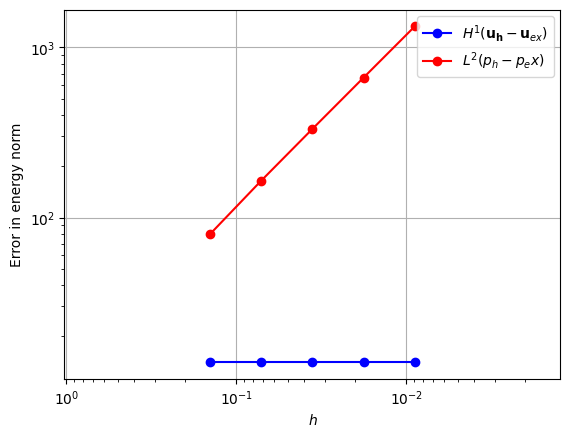

In [16]:
element_u = VectorElement("Lagrange", "triangle", 1)
element_p = FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p)

## P2-DG0 {cite}`fortin-phd`

One way to obtain convergence with a piecewise constant pressure space is to use a piecewise quadratic space for the velocity.

<img src='./img/element-Lagrange-triangle-2-dofs-large.png' width="100px"/><img src='./img/element-Lagrange-triangle-0-dofs-large.png' width="100px" />

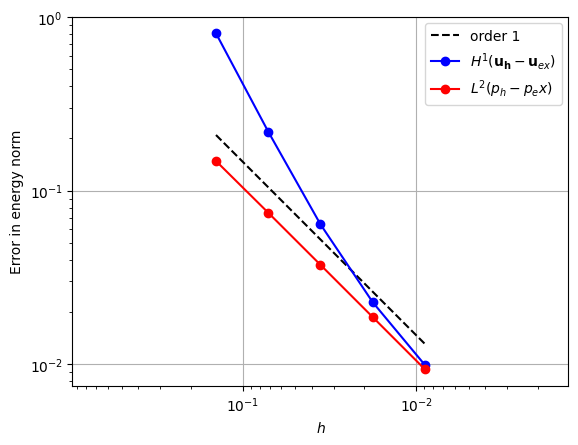

In [17]:
element_u = VectorElement("Lagrange", "triangle", 2)
element_p = FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p, convergence_p=1)

## Crouzeix-Raviart 

Alternatively, the same order convergence can be achieved using fewer degrees of freedom if a Crouzeix-Raviart {cite}`crouzeix-raviart` element is used for the velocity space.

<img src='./img/element-Crouzeix-Raviart-triangle-1-dofs-large.png' width="100px"/><img src='./img/element-Lagrange-triangle-0-dofs-large.png' width="100px"/>

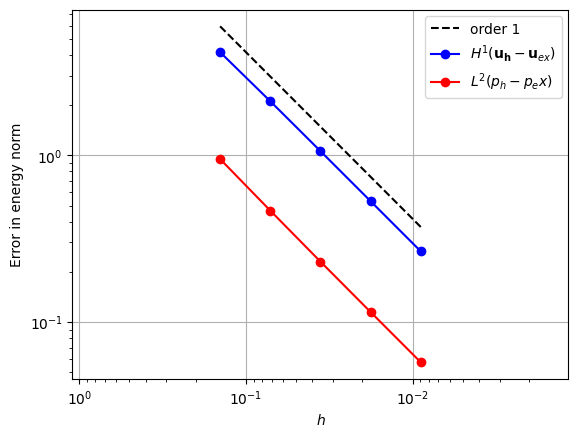

In [18]:
element_u = VectorElement("CR", "triangle", 1)
element_p = FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p, 1)

## Piecewise linear pressure space

When using a piecewise linear pressure space, we could again try using a velocity space one degree higher, but we would again observe that there is no convergence. In order to achieve convergence, we can augment the quadratic space with a cubic bubble function on the triangle {cite}`crouzeix-falk`.

<img src='./img/element-bubble-enriched-Lagrange-triangle-2-dofs-large.png' width="100px" /><img src='./img/element-Lagrange-triangle-1-dofs-large.png' width="100px" />

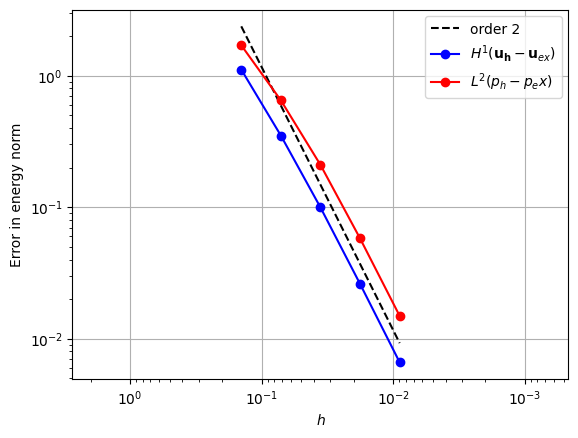

In [19]:
enriched_element = (
    FiniteElement("Lagrange", "triangle", 2)
    + FiniteElement("Bubble", "triangle", 3))
element_u = VectorElement(enriched_element)
element_p = FiniteElement("DG", "triangle", 1)
error_plot(element_u, element_p, 2)

## Taylor-Hood Element

Continuous Lagrange spaces for pressure and velocity.

<img src='./img/element-Lagrange-triangle-3-dofs-large.png' width="100px" /><img src='./img/element-Lagrange-triangle-2-dofs-large.png' width="100px" />

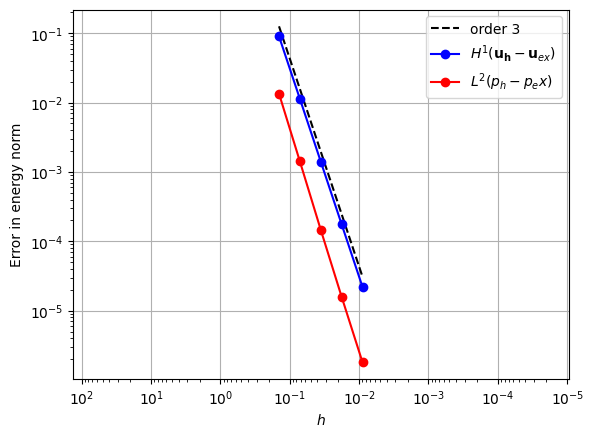

In [20]:
element_u = VectorElement("CG", "triangle", 3)
element_p = FiniteElement("CG", "triangle", 2)
error_plot(element_u, element_p, 3)

## Piecewise quadratic pressure space {cite}`crouzeix-falk`

When using a piecewise quadratic space, we can use a cubic velocity space augmented with quartic bubbles.

<img src='./img/element-bubble-enriched-Lagrange-triangle-3-dofs-large.png' width="100px" /><img src='./img/element-Lagrange-triangle-2-dofs-large.png' width="100px" />

### Custom elements

We have to define this velocity element as a custom element (it cannot be created as an enriched element, as the basis functions of degree 3 Lagrange and degree 4 bubbles are not linearly independent). More examples of how custom elements can be created can be found [in the Basix documentation](https://docs.fenicsproject.org/basix/v0.5.0/python/demo/demo_custom_element.py.html).

#### Defining the polynomial space

When creating a custom element, we must input the coefficients that define a basis of the set of polynomials that our element spans. In this example, we will represent the 9 functions in our space in terms of the 10 orthonormal polynomials of degree $\leqslant3$ on a quadrilateral, so we create a 9 by 10 matrix.

A polynomial $f$ on the triangle can be written as
$$f(x,y)=\sum_i\left(\int_0^1\int_0^{1-y}f(x, y)q_i(x, y) \,\mathrm{d}x\,\mathrm{d}y\right)q_i(x,y),$$
where $q_0$, $q_1$, ... are the orthonormal polynomials. The entries of our coefficient matrix are these integrals.

In [21]:
wcoeffs = np.zeros((12, 15))
pts, wts = basix.make_quadrature(basix.CellType.triangle, 8)
poly = basix.tabulate_polynomials(basix.PolynomialType.legendre, basix.CellType.triangle, 4, pts)
x = pts[:, 0]
y = pts[:, 1]
for j, f in enumerate([
    1, x, y, x ** 2 * y, x * y ** 2, (1 - x - y) ** 2 * y, (1 - x - y) * y ** 2,
    x ** 2 * (1 - x - y), x * (1 - x - y) ** 2,
    x * y * (1 - x - y), x ** 2 * y * (1 - x - y), x * y ** 2 * (1 - x - y)
]):
    for i in range(15):
        wcoeffs[j, i] = sum(f * poly[i, :] * wts)

#### Interpolation

Next, we compute the points and matrices that define how functions can be interpolated into this space. For this element, all the DOFs are point evaluations, so we create lists of these points and (reshaped) identity matrices.

In [22]:
x = [[], [], [], []]
x[0].append(np.array([[0.0, 0.0]]))
x[0].append(np.array([[1.0, 0.0]]))
x[0].append(np.array([[0.0, 1.0]]))
x[1].append(np.array([[2 / 3, 1 / 3], [1 / 3, 2 / 3]]))
x[1].append(np.array([[0.0, 1 / 3], [0.0, 2 / 3]]))
x[1].append(np.array([[1 / 3, 0.0], [2 / 3, 0.0]]))
x[2].append(np.array([[1 / 4, 1 / 4], [1 / 2, 1 / 4], [1 / 4, 1 / 2]]))

M = [[], [], [], []]
for _ in range(3):
    M[0].append(np.array([[[[1.]]]]))
for _ in range(3):
    M[1].append(np.array([[[[1.], [0.]]], [[[0.], [1.]]]]))
M[2].append(np.array([[[[1.], [0.], [0.]]], [[[0.], [1.], [0.]]], [[[0.], [0.], [1.]]]]))

#### Creating the element

We now create the element by passing in the information we created above, as well as the cell type, value shape, number of derivatives used by the DOFs, map type, whether the element is discontinuous, the highest degree Lagrange space that is a subspace of the element, and the polynomial degree of the element.

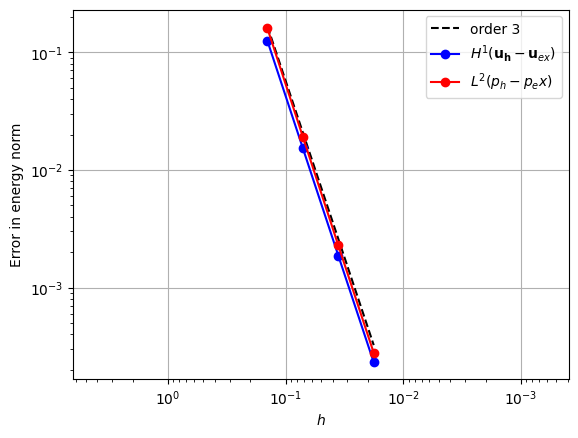

In [25]:
p3_plus_bubbles = basix.create_custom_element(
    basix.CellType.triangle, [], wcoeffs, x, M, 0, basix.MapType.identity,
    basix.SobolevSpace.H1, False, 3, 4)
element_u = VectorElement(basix.ufl_wrapper.BasixElement(p3_plus_bubbles))
element_p = FiniteElement("DG", "triangle", 2)
error_plot(element_u, element_p, 3, refinements=4)

## References

The images of elements used in this example were taken from DefElement {cite}`defelement`.

```{bibliography}
:style: unsrt
```